## E10. 뉴스 요약봇 만들기
뉴스 기사 데이터로 추출적요약(extraction summary)과 추상적요약(abstraction summary)를 수행하는 모델을 만들어 보자. 

### Executive Summary 

추출적 요약과 추상적 요약을 비교해 본 결과 전반적으로 추출적 요약이 더 길지만 훨씬 의미 전달이 잘 되는걸 볼 수가 있었다.        

추상적 요약은 내용이 원문과 맞지 않는것이 대부분이다. 여러가지 이유가 있겠지만 한가지 눈에 띄는것은 original text 와 전처리된 text를 비교했을때의 차이점이었다. 전처리된 text를 읽었을때 이해가 가지 않는 부분이 많았다. 불용어, 소유격, 숫자가 원문에서 없어짐에 따라서 내용이 이해하기 힘들어진것 같다. 노드에 있는 아마존 리뷰 같은 길지 않고 내용의 복잡성이 떨어지는 text에서는 문제가 되지 않을 수도 있으나 신문기사처럼 단어들이 중요성을 갖을 때는 전처리에 대해서 다시 한번 고민해 볼 필요가 있을것 같다.     

또한 실제요약도(headline) 말이 되지 않는 것들이 간혹 보인다. 그러므로 모델을 돌리기 전에 data를 좀 더 살펴볼 필요가 있을것 같다.    

마지막으로, 다음에는 추상적 요약의 모델에 변화를 주어 성능을 재평가 해보고 싶다. 

### Table of Contents
* Abstraction Summary 
* Extraction Summary 
* Comparison between Abstraction and Extraction Approaches

### 필요한 모듈 불러오기 

In [5]:
import os 
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import nltk 
nltk.download('stopwords')
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import multiprocessing as mp   
from multiprocessing import Pool
import numpy as np
import time
from functools import partial  
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from attention import AttentionLayer

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### 데이터 불러오기 

In [6]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [7]:
data.sample(10)

,headlines,text
91155,Comedy show Hum Paanch to have a third season:...,"As per reports, the comedy show Hum Paanch wil..."
68557,I'm not forming a new party as of now: Mulayam...,Samajwadi Party (SP) patron Mulayam Singh Yada...
77020,Plans of military operations against India: Ch...,"According to a state-run daily in China, the c..."
48591,Samsung Chairman named suspect in $7.5 mn tax ...,South Korean police have named 76-year-old Sam...
83331,"BCCI to earn Ã¢ÂÂ¹2,199 crore from IPL naming...","BCCI is set to earn Ã¢ÂÂ¹2,199 crore after Ch..."
53987,Peter Thiel's Founders Fund bought $20 mn Bitc...,PayPal Co-founder and early Facebook investor ...
18911,Bombay HC slams cops over Bhima-Koregaon press...,The Bombay High Court on Monday slammed the Ma...
67045,Govt proposes airing public interest messages ...,The Information and Broadcasting (I&B) Ministr...
52626,Virus kills over 170 dolphins in Brazil,Brazilian scientists have said that a virus is...
31010,Nude portrait by Italian painter auctioned for...,A nude portrait by Italian painter Amedeo Modi...


In [8]:
data.shape

(98401, 2)

### 추상적 요약 (Abstraction Summary) 

### 전처리 
1. 중복이 있는지 확인해준다. 
2. 정규화(text normalization): [출처](https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python)
3. 불용어(stop words) 제거: NLTK에서 제공하는 불용어 리스트를 참조
4. 데이터의 최대길이 지정
5. 결측치 제거
6. 시작토큰과 종료 토큰 추가하기 


#### 중복 

In [9]:
data.drop_duplicates(subset = ['text'], inplace=True)

#### 정규화, 불용어 

In [10]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [11]:
print('불용어 개수 :', len(stopwords.words('english')))

불용어 개수 : 179


In [12]:
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [13]:
start = time.time()

# num_cores 만큼 쪼개진 데이터를 전처리하여 반환합니다
def appendTexts(sentences, remove_stopwords):
  texts = []
  for s in sentences:
    texts += preprocess_sentence(s, remove_stopwords),
  return texts

def preprocess_data(data, remove_stopwords=True):
  start_time = time.time()
  num_cores = mp.cpu_count()  # 컴퓨터의 코어 수를 구합니다

  text_data_split = np.array_split(data, num_cores)  # 코어 수만큼 데이터를 배분하여 병렬적으로 처리할 수 있게 합니다
  pool = Pool(num_cores)

  processed_data = np.concatenate(pool.map(partial(appendTexts, remove_stopwords=remove_stopwords), text_data_split))  # 각자 작업한 데이터를 하나로 합쳐줍니다
  pool.close()
  pool.join()
  print(time.time() - start_time, " seconds")
  return processed_data

clean_text = preprocess_data(data['text'])  # 클라우드 기준으로 3~4분 정도 소요 됩니다
print(clean_text)

clean_headlines = preprocess_data(data['headlines'], remove_stopwords=False) # 클라우드 기준 1분정도 소요됩니다.
print(clean_headlines)

229.66391921043396  seconds
['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers'
 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit'
 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history'
 ...
 'according reports new version science fiction film matrix development michael jordan reportedly play lead role film screenwriter zak

In [14]:
data['text'] = clean_text
data['headlines'] = clean_headlines

#### 최대길이 지정
text, headlines 길이는 정규분포 모양으로 고르게 분포되어 있다. 
최대길이는 text= 45, headlines=13으로 해 주기로 한다. 
최대길이보다 긴 문장들을 없어주고 난 뒤의 데이터의 갯수는 97863. 원본보다 500개 정도가 적다. 

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534


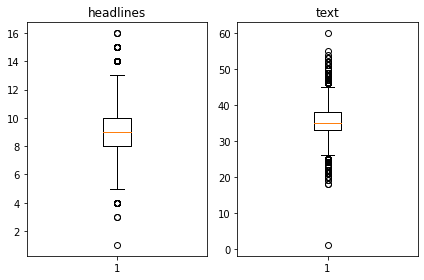

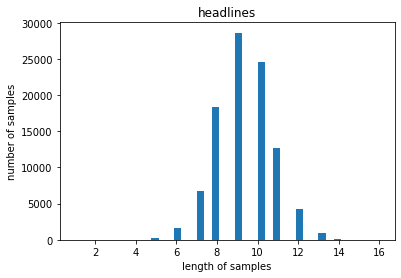

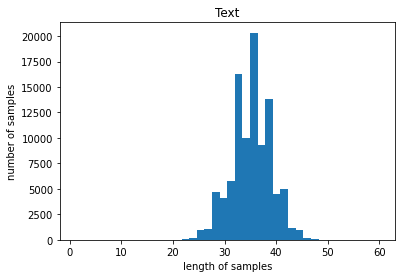

In [15]:
text_len = [len(s.split()) for s in data['text']]
summary_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(summary_len)
plt.title('headlines')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('text')
plt.tight_layout()
plt.show()

plt.title('headlines')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [16]:
text_max_len = 45
headlines_max_len = 13

In [17]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [18]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len,  data['headlines'])

전체 샘플 중 길이가 45 이하인 샘플의 비율: 0.9967771451809678
전체 샘플 중 길이가 13 이하인 샘플의 비율: 0.9981699877999186


In [19]:
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 97863


#### 결측치 제거
결측치 없음

In [20]:
data.isnull().sum()

headlines    0
text         0
dtype: int64

#### 시작, 종료 토큰 추가 
* 시작: 'sostoken'
* 종료: 'eostoken'

In [21]:
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform c...,sostoken delhi techie wins free food from swig...,delhi techie wins free food from swiggy for on...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
4,have known hirani for yrs what if metoo claims...,speaking sexual harassment allegations rajkuma...,sostoken have known hirani for yrs what if met...,have known hirani for yrs what if metoo claims...


#### encoder, decoder  
* encoder_input (인코더 입력): text    
* decoder_input (디코더의 입력): 'sostoken'+ headlines 
* decoder_target (디코더의 레이블): headlines + 'eostoken'    

In [22]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

In [23]:
#indices = np.arange(encoder_input.shape[0])
#np.random.shuffle(indices)
#print(indices)

In [24]:
#encoder_input = encoder_input[indices]
#decoder_input = decoder_input[indices]
#decoder_target = decoder_target[indices]

### train/test 나눠주기

In [25]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 19572


In [26]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 78291
훈련 레이블의 개수 : 78291
테스트 데이터의 개수 : 19572
테스트 레이블의 개수 : 19572


### 단어집합(vocabulary) 만들기 (encoder_input_train)
* Tokenizer
* encoder_input_train 으로 vocabulary 생성 (fit_on_texts이용)
* text_to_sequences 으로 토큰을 정수로 바꾸기 

In [27]:
src_tokenizer = Tokenizer() 
src_tokenizer.fit_on_texts(encoder_input_train) 

In [28]:
threshold = 10
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 67883
등장 빈도가 9번 이하인 희귀 단어의 수: 49743
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 18140
단어 집합에서 희귀 단어의 비율: 73.27755108053563
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.491020036303802


In [29]:
src_vocab = 50000
src_tokenizer = Tokenizer(num_words=src_vocab) 
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성 

In [30]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)
print(encoder_input_test[1])

[9508, 1740, 11815, 3047, 7812, 1538, 1738, 565, 582, 7573, 1, 6099, 10, 1036, 23, 5885, 431, 1856, 11815, 366, 5344, 1931, 14629, 1, 1550, 36, 23, 290, 27, 7573]


### 단어집합(vocabulary) 만들기 (decoder_input_train)
* Tokenizer
* decoder_input_train 으로 vocabulary 생성 (fit_on_texts이용)
* text_to_sequences 으로 토큰을 정수로 바꾸기 
* headlines 중에서 vocabulary 생성후 없어진 문장이 있나 확인결과, 없어진 문장은 없었다. 

In [31]:
tar_tokenizer = Tokenizer() 
tar_tokenizer.fit_on_texts(decoder_input_train) 

In [32]:
threshold = 10
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 29645
등장 빈도가 9번 이하인 희귀 단어의 수: 22038
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 7607
단어 집합에서 희귀 단어의 비율: 74.33968628773823
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 6.99683498244809


In [33]:
tar_vocab = 20000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train) 
tar_tokenizer.fit_on_texts(decoder_target_train)

In [34]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)
print(decoder_input_test[1])

[1, 10, 49, 4862, 82, 62, 1283, 204, 577, 487, 4760, 11164]


In [35]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence)==1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence)==1]

print('삭제할 훈련 데이터: ', len(drop_train))
print('삭제할 테스트 데이터: ',len(drop_test))

삭제할 훈련 데이터:  0
삭제할 테스트 데이터:  0


### 패딩하기 
* maxlen을 기준으로 'post'에 패딩을 넣어줌 

In [36]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')

### 모델 설계 

* 모델에 대한 설명 
1. seq2seq를 사용 [출처](https://blog.naver.com/sooftware/221784419691)   
    1) encoder, decoder 모델    
    2) encoder: 입력데이터를 encoding 해서 vector의 형태로 압축한다 (context vector). LSTM을 사용해주면 데이터를 h, hidden state vector로 바꿔준다. 특정 길이의 시계열 데이터를 고정 길이 벡터로 변환하는 작업.     
    3) decoder: encoder로부터 전달받은 h와 이번 layer의 input(처음 layer는 'sostoken'이 input)을 바탕으로 affine, softmax를 거쳐서 다음 단어를 예측.     
         
2. RNN 계열 중 LSTM을 사용. LSTM은 4개의 layer들로 구성돼어 있다. 위에 수평으로 있는 선이 cell state의 흐름, 밑에 선은 hidden state의 흐름을 나타낸다.  [출처](https://dgkim5360.tistory.com/entry/understanding-long-short-term-memory-lstm-kr)    
    1) forget gate layer: 전 layer에서 나온 cell state로부터 어떤 정보를 버릴것인지 정하는것. 전 layer에서 나온 hidden state의 값과 이번 input인 x를 linear regression/sigmoid layer에 통과시켜서 값이 1이면 모든 정보를 보존시켜서 cell state으로 전달시키고, 0이면 값을 버린다.    
    2) input gate layer: 이번 layer의 input인 x에서 어떤 정보를 cell state에 저장할것인지 결정한다.     
    3) cell state update: 1)과 2)를 통해 cell state을 업데이트 시켜준다.     
    4) output gate layer: 전 layer의 hidden state과 이번 layer의 x 값을 3)에서 update 된 cell state을 반영해서 hidden state의 output이 생성된다. output은 또 다음 layer의 input으로 간다.     
3. 디코더의 예측 시퀀스에는 시작 토큰 SOS와 예측 토큰 EOS를 시퀀스의 앞, 뒤로 붙임.   
4. seq2seq를 구동시키면 디코더는 시작 토큰을 입력받아 예측을 시작.   
5. seq2seq 기본 모델과 달리, 어텐션 메커니즘을 이용해 인코더의 hidden state의 중요도를 취합한 컨텍스트 벡터를 디코더 스텝별로 계산. [출처](https://blog.naver.com/sooftware/221784472231)   
    1) seq2seq의 문제점    
        * 하나의 고정된 크기에 벡터를 압축하다보니 정보손실이 일어나고 문장이 길어지면 성능이 떨어진다.      
        * vanishing gradient problem    
    2) Attention mechanism: decoder가 final hidden state과 cell state를 input으로 받을 뿐 아니라, decoder에서 출력결과를 예측할 때 마다 encoder의 필요한 hidden state들을 반영한다 (final hidden state과 더불어). 이 때 어느 encoder의 hidden state을 얼마나 참고해야 할 지 결정해야 하는데, 이것은 softmax 를 통해서 각 hidden state의 attention distribution을 정해준다. softmax 의 총합은 1이므로, hidden state중에 값이 큰 것이 decoding 할때 많이 반영된다.      
6. 계산된 컨텍스트 벡터를 이용해서 디코더는 다음 등장할 단어를 예측.    
   
   
* 코딩 순서  
    * encoder 설계   
    * decoder 설계    
    * attention mechanism 적용    

### encoder 설계 
* Embedding (dimension=128) 
* LSTM 1 (hidden state=256, hidden state은 뉴런의 갯수, dimensionality of the output space)
* LSTM 2
* LSTM 3

In [37]:
embedding_dim = 128
hidden_size = 256

encoder_inputs = Input(shape=(text_max_len,))

enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

encoder_lstm3 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c = encoder_lstm3(encoder_output2)

### decoder 설계 
* Embedding (dimension=128) 
* LSTM을 설계하는것은 encoder와 비슷하지만 hidden state(state_h), cell state(state_c)를 넣어주어야 한다. state_h, state_c는 encoder에서 나온 output이다. 
* decoder 출력층
* 모델 정의 

In [38]:
# decoder 설계 
decoder_inputs = Input(shape=(None,))

dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

### Attention Mechanism 추가 

In [39]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", filename="attention.py")
from attention import AttentionLayer

In [40]:
# attention함수 
attn_layer = AttentionLayer(name='attention_layer')

# encoder, decoder 모든 time step의 hidden state을 attention layer에 전달하고 결과를 리턴 
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# attention output과 decoder의 hidden state연결 
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

In [41]:
# decoder 출력층 
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

In [42]:
# 모델 
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)

### 모델 훈련 
* optimizer = adam      
* loss = sparse categorical crossentropy 
* Early stopping
    * Stop training when a monitored metric has stopped improving. 
    * validation loss를 기준점으로 삼았다. 
    * patience=2: 2 epoch 동안 validation loss가 imporve 하지 않으면 2 epoch 후 training이 멈추도록 설계.
* 결과를 history1에 저장하고 loss와 validation loss를 시각화 하였다. 

In [43]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history1 = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, 
                    validation_data=([encoder_input_test, decoder_input_test], decoder_target_test),
                    batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
306/306 [==============================] - 311s 972ms/step - loss: 6.4458 - val_loss: 5.2282
Epoch 2/50
306/306 [==============================] - 299s 977ms/step - loss: 5.3412 - val_loss: 4.9032
Epoch 3/50
306/306 [==============================] - 298s 974ms/step - loss: 4.8769 - val_loss: 4.5330
Epoch 4/50
306/306 [==============================] - 296s 969ms/step - loss: 4.4221 - val_loss: 4.2832
Epoch 5/50
306/306 [==============================] - 296s 968ms/step - loss: 4.0616 - val_loss: 4.1402
Epoch 6/50
306/306 [==============================] - 291s 950ms/step - loss: 3.7821 - val_loss: 4.0350
Epoch 7/50
306/306 [==============================] - 291s 951ms/step - loss: 3.5504 - val_loss: 3.9622
Epoch 8/50
306/306 [==============================] - 290s 949ms/step - loss: 3.3383 - val_loss: 3.9137
Epoch 9/50
306/306 [==============================] - 291s 952ms/step - loss: 3.1675 - val_loss: 3.8836
Epoch 10/50
306/306 [==============================] - 300s 982m

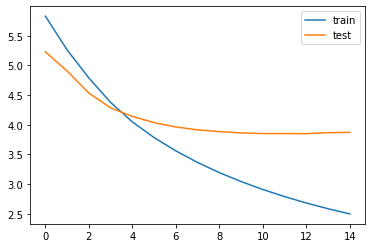

In [44]:
plt.plot(history1.history['loss'], label='train')
plt.plot(history1.history['val_loss'], label='test')
plt.legend()
plt.show()

### inference 모델 
* 정수에서 단어로 바꾸어줌 
* encoder와 decoder를 따로 설계해 주어야함 

In [45]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [46]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [47]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [48]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

### 모델 테스트 

In [49]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [50]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : brihanmumbai municipal corporation denied ganesh mandal coordination committee demand take approval process setting mandals online committee claimed single window clearance system introduced improve mandal approval rate ineffective reportedly meet mayor vishwanath mahadeshwar demand better clearance system 
실제 요약 : bmc denies ganesh mandal demand for online approval 
예측 요약 :  mumbai civic body to ban fine for repairs civic body


원문 : year old student harpreet singh happy punjab jalandhar allegedly got girlfriend raped could use excuse avoid marrying according reports two happy friends took abandoned haveli raped day supposed meet parents reports added 
실제 요약 : college student gets girlfriend raped to avoid marriage 
예측 요약 :  girl gets married to girl for marrying girl in law


원문 : mumbai residents protesting outside brihanmumbai municipal corporation bandra office every monday friday since july complaints resolved months complaints filed bmc public grievance registration system 

예측 요약 :  arjun rampal turns showstopper at lakm fashion week


원문 : emmanuel portrays game thrones said first nude scene show featured season second episode big deal added strange become good friends co star jacob anderson portrays grey worm fine obviously done really respectfully said 
실제 요약 : my first game of thrones nude scene was big deal 
예측 요약 :  anushka confirms got engaged to play game of thrones season


원문 : former adult star mia khalifa started youtube channel review christopher nolan directorial dunkirk video review said know whole thing lasted hours rescue mission took two half months mia also slammed dunkirk tweeting love nolan dunkirk sucked 
실제 요약 : mia khalifa starts youtube channel with review of 
예측 요약 :  sushant approached for star in film on tv show film maker


원문 : actor neil nitin mukesh took twitter share first look poster upcoming film co stars alongside jackie shroff film also stars kay kay menon karan singh grover dhar film directed bhatt cast expected begin

예측 요약 :  infosys posts its first ever quarterly profit in


원문 : civil servant responsible sweden largest ever data leak punished fine equivalent half month salary lakh discovered nearly months ago leak affected private data every swedish citizen driver license data exposed sweden transport agency outsourced management database 
실제 요약 : woman behind sweden largest data leak fined half month pay 
예측 요약 :  uk fined crore fine for failing to get fine


원문 : bengaluru based education technology startup byju raised undisclosed amount funding chinese internet conglomerate tencent september byju raised crore clutch investors including chan zuckerberg initiative sequoia capital byju also acquired edtech platforms pearson earlier year 
실제 요약 : indian edtech startup byju raises funding from tencent 
예측 요약 :  bengaluru startup raises mn in series funding


원문 : former chief marketing officer furniture tailer urban ladder sanjay gupta joined uber head marketing india according reports gupta left u

### 추출적 요약 (Extraction Summary) 
추상적 요약에서 테스트한 데이터를 summarize 함수를 사용해, extraction summary를 해주었다. headline max 와 같이 word를 13으로 제한하려고 했으나, summarize 함수는 문단에서 그 문단을 대표하는 문장을 그대로 가져오기 때문에 문장의 길이가 너무 짧으면 아무것도 return 하지 않으므로 words를 30으로 넉넉하게 잡아주었다.  

In [133]:
from summa.summarizer import summarize

In [101]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data_ext = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [105]:
data_ext.astype(str)
sample_d = data_ext.loc[data_ext['text'].str.contains("ganesh mandal", case=False)]
sample_d

,headlines,text
73918,Delhi residents to not immerse Ganesh idols in...,A Delhi-based Ganesh mandal association has an...
74487,Mumbai's Ganpati mandals to promote organ dona...,Over 30 Ganesh Mandals in Mumbai have announce...
76947,BMC to train Ganesh mandal volunteers in disas...,The Brihanmumbai Municipal Corporation (BMC) w...
78812,BMC denies Ganesh mandal's demand for online a...,The Brihanmumbai Municipal Corporation (BMC) h...
79127,Ganesh mandals in Mumbai oppose Silence Zones,Ganesh mandals across Mumbai have been demandi...
91206,"Bihar van driver attacked for scaring a cow, m...","Amid rising incidents of cow vigilantism, the ..."


In [140]:
data_test_ex = pd.DataFrame(data_ext[78812:78862]).astype(str)
data_test_ex.head()

,headlines,text
78812,BMC denies Ganesh mandal's demand for online approval,"The Brihanmumbai Municipal Corporation (BMC) has denied a Ganesh mandal coordination committee's demand to take the approval process for setting up mandals online. The committee claimed that the single-window clearance system which was introduced in 2015 to improve mandal approval rate was ineffective. Reportedly, it will now meet Mayor Vishwanath Mahadeshwar to demand a better clearance system."
78813,College student gets girlfriend raped to avoid marriage,"A 19-year-old student, Harpreet Singh Happy, in Punjab's Jalandhar allegedly got his girlfriend raped so that he could use it as an excuse to avoid marrying her, according to reports. Two of Happy's friends took her to an abandoned haveli and raped her on the same day she was supposed to meet his parents, reports added."
78814,Mumbaikars protest outside BMC on 192 unresolved complaints,"Mumbai residents have been protesting outside the Brihanmumbai Municipal Corporation's (BMC) Bandra office every Monday and Friday since July 7 over 192 complaints that haven't been resolved in 18 months. The complaints were filed in BMC's public grievance registration system set up in 2015. The complaints include illegal encroachments, drainage issues, potholes, and tree cutting among others."
78815,We don't care at all about US travel ban: N Korea,"North Korean officials have said they do not care ""at all"" about the US' ban on its citizens travelling to the country, saying that it will have no effect on its tourism industry. The ban, which will reportedly be enacted this week, comes after the death of a US student who was arrested while on a North Korea tour."
78816,Australian pastor calls Islam 'a cancer we must destroy',"An Australian Baptist church has come under fire after a video surfaced of its pastor describing Islam as ""a cancer we must destroy"". Keith Piper described the Quran as ""a virus infecting the brains [of Muslims]"", adding that Islam is ""culturally incompatible with western Christian values"". He further called for a ban on Muslim immigration."


In [121]:
data_test_ex.count()

headlines    50
text         50
dtype: int64

In [130]:
pd.options.display.max_colwidth = None

In [145]:
data_test_ex['ext_summary'] = data_test_ex['text'].apply(lambda x : summarize(x, words=30))
print(data_test_ex['ext_summary'])

78812                                                                                                                                                              The committee claimed that the single-window clearance system which was introduced in 2015 to improve mandal approval rate was ineffective.
78813                                                                                                                  A 19-year-old student, Harpreet Singh Happy, in Punjab's Jalandhar allegedly got his girlfriend raped so that he could use it as an excuse to avoid marrying her, according to reports.
78814    Mumbai residents have been protesting outside the Brihanmumbai Municipal Corporation's (BMC) Bandra office every Monday and Friday since July 7 over 192 complaints that haven't been resolved in 18 months.\nThe complaints were filed in BMC's public grievance registration system set up in 2015.
78815                                                                                      

### 평가 (Comparison b/w Abstraction and Extraction)
test data 중에 5개만 모아서 평가해 보았다. 평가를 위해서 1) original text 2) 전처리된 text 3)실제요약 4) abstraction 요약 5) extraction 요약 이렇게 5개를 비교해 보았다. 

전반적으로 extraction 요약이 더 길지만 훨씬 의미 전달이 잘 되는걸 볼 수가 있다. abstraction 요약은 내용이 원문과 맞지 않는것이 대부분이다. 여러가지 이유가 있겠지만 한가지 눈에 띄는것은 original text 와 전처리된 text를 비교했을때의 차이점이었다. 전처리된 text를 읽었을때 이해가 가지 않는 부분이 많았다. 불용어, 소유격, 숫자가 원문에서 없어짐에 따라서 내용이 이해하기 힘들어진것 같다. 노드에 있는 아마존 리뷰 같은 길지 않은 text에서는 문제가 되지 않을 수도 있으나 신문기사처럼 단어들이 중요성을 갖을 때는 전처리에 대해서 다시 한번 고민해 볼 필요가 있을것 같다. 또한 실제요약도 말이 되지 않는 것들이 간혹 보인다. 그러므로 모델을 돌리기 전에 data 를 좀 더 살펴볼 필요가 있을것 같다. 

In [146]:
for i in range(50, 55):
    print("원문 text :", data_test_ex['text'][i-50:i-49])
    print("전처리된 text :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("Abstraction 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("Extraction 요약: ", data_test_ex['ext_summary'][i-50:i-49])
    print("\n")

원문 text : 78812    The Brihanmumbai Municipal Corporation (BMC) has denied a Ganesh mandal coordination committee's demand to take the approval process for setting up mandals online. The committee claimed that the single-window clearance system which was introduced in 2015 to improve mandal approval rate was ineffective. Reportedly, it will now meet Mayor Vishwanath Mahadeshwar to demand a better clearance system. 
Name: text, dtype: object
전처리된 text : brihanmumbai municipal corporation denied ganesh mandal coordination committee demand take approval process setting mandals online committee claimed single window clearance system introduced improve mandal approval rate ineffective reportedly meet mayor vishwanath mahadeshwar demand better clearance system 
실제 요약 : bmc denies ganesh mandal demand for online approval 
Abstraction 요약 :  mumbai civic body to ban fine for repairs civic body
Extraction 요약:  78812    The committee claimed that the single-window clearance system which was intro